In [0]:
!pip install --upgrade tensorflow

Requirement already up-to-date: tensorflow in /usr/local/lib/python3.6/dist-packages (2.0.0)


In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
import skimage
import random
from scipy.signal import hilbert
from scipy.io import loadmat
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
print(tf.__version__)

2.0.0


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
%cd drive/'My Drive'/BME590_Machine_Learning

/content/drive/My Drive/BME590_Machine_Learning


In [0]:
data = loadmat('OASBUD.mat')['data'][0] # mat file is dict with header, we just want the data key (which is stored as a list of lists)
# each of the 100 data points consists of 7 arrays
# array 0: patient's unique ID
# array 1: first scan plane (first set of rf dta)
# array 2: second scan plane (second set of rf data)
# array 3: region of interest for first scan plane
# array 4: region of interest for second scan plane
# array 5: BI-RADS category (low, medium, high probability of malignancy)
# array 6: label (0 = benign, 1 = malignant)

In [0]:
# Use hilbert function to create a dB envelope image of the data
def preprocessing(rf_data):
    envelope_image = np.abs(hilbert(rf_data))
    envelope_image = 20 * np.log10(envelope_image/np.max(envelope_image))   
    return envelope_image

In [0]:
# Separate oasbud data into images and their labels
labeled_data = []
for n in range(len(data)):
  labeled_data.append((preprocessing(data[n][1]), data[n][3], data[n][6][0])) # data for scan 1, roi for scan 1, label
  labeled_data.append((preprocessing(data[n][2]), data[n][4], data[n][6][0])) # data for scan 2, roi for scan 2, label

In [0]:
# Data augmentation:
# semi-randomly crop the image to include the whole tumor several times
# resize the image to a square of given size (images start as rectangular matrices of differing dimensions)
# augment data with left-right flip and up-down flip

def augment_data(labeled_data):
  augmented_labeled_data = []
  new_im_size = 320
  for data in labeled_data:
    roi = data[1]
    x0 = 0
    while x0 < len(roi) and 1 not in roi[x0]:
      x0 += 1
    x1 = x0
    while x1 < len(roi) and 1 in roi[x1]:
      x1 += 1
    y0 = 0
    while y0 < len(roi[0]) and 1 not in roi[:,y0]:
      y0 += 1
    y1 = y0
    while y1 < len(roi[0]) and 1 in roi[:,y1]:
      y1 += 1
    ctr = 0
    x_bound = np.min([x0, len(roi)-x1, 20])
    y_bound = np.min([y0, len(roi[0])-y1, x1-x0 - (y1-y0)])
    while ctr < 10:
      ctr += 1
      shift_x = random.randint(0, x_bound) 
      shift_y = random.randint(0, y_bound)
      if x1-x0 < len(roi[0]):
        new_im = data[0][x0-shift_x:x1+(20-shift_x), y0-shift_y:y1+(y_bound-shift_y)]
      else:
        new_im = data[0][x0-shift_x:x1+(20-shift_x), :]
      new_im = skimage.transform.resize(new_im, (new_im_size, new_im_size))
      augmented_labeled_data.append((new_im, data[2]))
      augmented_labeled_data.append((np.fliplr(new_im), data[2]))
      augmented_labeled_data.append((np.flipud(new_im), data[2]))
  return np.array(augmented_labeled_data)

augmented_labeled_data = augment_data(labeled_data)

In [0]:
# Shuffle and split data into train and test datasets
random.shuffle(augmented_labeled_data)

x_train_class = augmented_labeled_data[:int(len(augmented_labeled_data)*.8),0]
y_train_class = augmented_labeled_data[:int(len(augmented_labeled_data)*.8),1]
x_test_class = augmented_labeled_data[int(len(augmented_labeled_data)*.8):,0]
y_test_class = augmented_labeled_data[int(len(augmented_labeled_data)*.8):,1]

x_train_class = np.array([x for x in x_train_class])[..., np.newaxis]
x_test_class = np.array([x for x in x_test_class])[..., np.newaxis]

train_ds_class = tf.data.Dataset.from_tensor_slices((np.asarray(x_train_class, np.float32), np.asarray(y_train_class, np.float32))).shuffle(10000).batch(128)
test_ds_class = tf.data.Dataset.from_tensor_slices((np.asarray(x_test_class, np.float32), np.asarray(y_test_class, np.float32))).batch(int(len(x_test_class)/2))

In [0]:
# Custom CNN model with physical layer
class CNN(tf.keras.Model):
    def __init__(self):
        super(CNN, self).__init__()
        self.dB_cutoff = tf.Variable(initial_value=.001, name='dB_cutoff', dtype='float32', trainable=True)
        self.conv1 = tf.keras.layers.Conv2D(filters=32, kernel_size=3,strides=1, padding='same', activation=tf.nn.leaky_relu)
        self.mp1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')
        self.bn1 = tf.keras.layers.BatchNormalization()
        self.conv2 = tf.keras.layers.Conv2D(filters=64, kernel_size=3,strides=1, padding='same', activation=tf.nn.leaky_relu)
        self.mp2 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')
        self.bn2 = tf.keras.layers.BatchNormalization()
        self.conv3 = tf.keras.layers.Conv2D(filters=128, kernel_size=3,strides=1, padding='same', activation=tf.nn.leaky_relu)
        self.mp3 = tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='same')
        self.bn3 = tf.keras.layers.BatchNormalization()
        self.flatten = tf.keras.layers.Flatten()
        self.d1 = tf.keras.layers.Dense(1000, activation=tf.nn.relu)
        self.do = tf.keras.layers.Dropout(.1)
        self.d2 = tf.keras.layers.Dense(2, activation=tf.nn.softmax)

    def apply_cutoff(self, envelope_image):
        # sets any dB value of the envelope image less than the cutoff to the cutoff value
        multiplier = -1000*self.dB_cutoff
        envelope_image = tf.cast(envelope_image, 'float32')
        mask = tf.less(envelope_image, multiplier*tf.ones_like(envelope_image))
        mask = tf.cast(mask, 'float') 
        mask = mask * multiplier
        envelope_image = tf.multiply(envelope_image, tf.cast(tf.greater_equal(envelope_image, multiplier), 'float')) + mask
        return 255.0*(envelope_image + multiplier)/(multiplier)

    def call(self, x):
        x = self.apply_cutoff(x)
        x = self.conv1(x)
        x = self.mp1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.mp2(x)
        x = self.bn2(x)
        x = self.conv3(x)
        x = self.mp3(x)
        x = self.bn3(x)
        x = self.flatten(x)
        x = self.d1(x)
        x = self.do(x)
        return self.d2(x)

model = CNN()

In [0]:
# Set up train/test steps and loss object
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=.001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)
    

# Train model, printing the current cutoff after each batch

EPOCHS = 3

for epoch in range(EPOCHS):
    for images, labels in train_ds_class:
        train_step(images, labels)
        tf.print(1000*model.dB_cutoff)

    for test_images, test_labels in test_ds_class:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))
    tf.print(1000*model.dB_cutoff)
        
    # Reset the metrics for the next epoch
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

40.9999962
41.7442741
42.3392563
42.8323517
43.275856
43.6996536
44.0694962
44.4077797
44.7101059
44.9812622
45.2331963
45.4601669
45.665329
45.8602486
46.0375557
46.1975632
46.3575287
46.5088539
46.6552887
46.8011475
46.9496231
47.0961189
47.2372322
47.3667
47.5040855
47.6545715
47.804039
47.9418411
48.075592
48.2053146
48.3323669
48.453434
48.5637932
48.6737137
48.7843628
48.8895264
48.9891357
49.085289
Epoch 1, Loss: 2060.341796875, Accuracy: 54.291664123535156, Test Loss: 747.3386840820312, Test Accuracy: 50.83333206176758
49.085289
49.182373
49.2771225
49.3684196
49.4541931
49.5361748
49.6117592
49.6846046
49.755085
49.8221703
49.8838959
49.940731
49.9929085
50.0421829
50.0875435
50.1294937
50.1687584
50.2057877
50.2400513
50.2717133
50.3015823
50.3290672
50.3548164
50.378643
50.4003372
50.4212494
50.4403419
50.4577293
50.4740486
50.4889755
50.5016785
50.5599327
50.6142654
50.6655159
50.7136917
50.758728
50.8038
50.8503151
50.8943481
Epoch 2, Loss: 151.84408569335938, Accuracy: 57

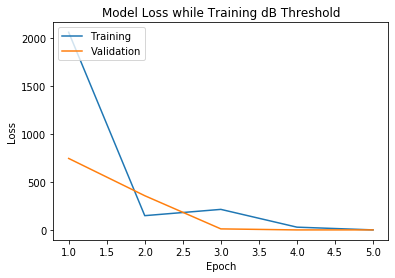

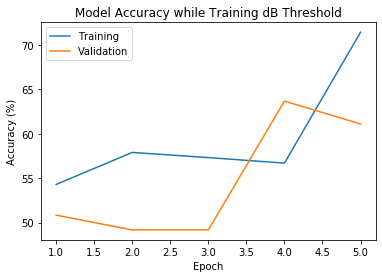

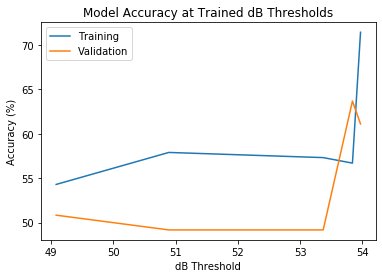

In [0]:
# Create plots to visualize training over time
epochs = [1, 2, 3, 4, 5]
db_values = [49.08, 50.89, 53.37, 53.84, 53.97]
train_loss = [2060.34, 151.84, 217.21, 32.16, 3.73]
test_loss = [747.34, 359.42, 14.18, 3.50, 3.78]
train_acc = [54.29, 57.89, 57.31, 56.69, 71.42]
test_acc = [50.83, 49.17, 49.17, 63.67, 61.10]

plt.plot(epochs, train_loss)
plt.plot(epochs, test_loss)
plt.title('Model Loss while Training dB Threshold')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(epochs, train_acc)
plt.plot(epochs, test_acc)
plt.title('Model Accuracy while Training dB Threshold')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

plt.plot(db_values, train_acc)
plt.plot(db_values, test_acc)
plt.title('Model Accuracy at Trained dB Thresholds')
plt.ylabel('Accuracy (%)')
plt.xlabel('dB Threshold')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()